<a href="https://colab.research.google.com/github/ekinfergan/Thesis_Jupyter_Final/blob/main/src/models/mc_lstm_fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - LSTM & GRU

In [ ]:
!git clone https://github.com/ekinfergan/Thesis_Jupyter_Final.git

In [ ]:
%cd Thesis_Jupyter_Final
!git pull
%cd ..


In [ ]:
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import pickle
from numpy import asarray

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, RocCurveDisplay, confusion_matrix, classification_report
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Embedding, concatenate, Dense, LSTM, GRU
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam, SGD, RMSprop, Adagrad

import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
from tensorflow.keras import backend as K

import functools

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)


import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
# just checkıng gpu ıs avaılable


try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
except ValueError:
  strategy = tf.distribute.get_strategy()

In [3]:
script_dir = os.path.dirname(os.path.abspath('mc_lstm-fix.ipynb'))
data_path = os.path.join(script_dir, 'Thesis_Jupyter_Final/src/')
os.getcwd()
print(data_path)

input_folder_path = os.path.join(data_path, 'input')
processed_folder_path = os.path.join(data_path, 'input/processed/normal')
results_folder_path =  os.path.join(data_path, "results")

# Create the folder if it doesn't exist
if not os.path.exists(results_folder_path):
    os.makedirs(results_folder_path)

/home2/s3985113/Thesis_Jupyter_Final/src/


In [4]:
senti_labels_dict = {1: 'Negative', 2: 'Neutral', 3: 'Positive'}
senti_labels_names = list(senti_labels_dict.values())
senti_labels_nums = list(senti_labels_dict.keys())
NUM_of_CLASSES = 3

VOCAB_SIZE = 11395
MAX_SEQ_LEN = 449
EMBEDDING_DIM = 100
NUM_OUTPUT_CLASSES = 3

In [5]:
train = pd.read_csv(os.path.join(processed_folder_path, "train.csv"))
val = pd.read_csv(os.path.join(processed_folder_path, "val.csv"))
test = pd.read_csv(os.path.join(processed_folder_path, "test.csv"))

x_train = train['x']
y_train = train['y']
x_val = val['x']
y_val = val['y']
x_test = test['x']
y_test = test['y']
import pickle

# Load encoded sequences
with open(os.path.join(processed_folder_path, "x_train_encoded.pkl"), "rb") as f:
    x_train_encoded = pickle.load(f)
with open(os.path.join(processed_folder_path, "x_val_encoded.pkl"), "rb") as f:
    x_val_encoded = pickle.load(f)
with open(os.path.join(processed_folder_path, "x_test_encoded.pkl"), "rb") as f:
    x_test_encoded = pickle.load(f)
print(f"x_train_encoded:\n{x_train_encoded[:5]}\n")

# Load embedding vectors
with open(os.path.join(processed_folder_path, "embedding_matrix.pkl"), "rb") as f:
    w2v_embedding_vectors = pickle.load(f)
print(f"embedding vectors: {w2v_embedding_vectors[10][:5]}...\n")

# Load encoded labels
with open(os.path.join(processed_folder_path, "y_train_encoded.pkl"), "rb") as f:
    y_train_encoded = pickle.load(f)
with open(os.path.join(processed_folder_path, "y_val_encoded.pkl"), "rb") as f:
    y_val_encoded = pickle.load(f)
with open(os.path.join(processed_folder_path, "y_test_encoded.pkl"), "rb") as f:
    y_test_encoded = pickle.load(f)
print(f"y_train_encoded:\n{y_train_encoded[:5]}\n")

x_train_encoded:
[[  96  549  929 ...    0    0    0]
 [ 453  240 1125 ...    0    0    0]
 [1260   67  312 ...    0    0    0]
 [ 127 1352 6694 ...    0    0    0]
 [ 529   10   69 ...    0    0    0]]

embedding vectors: [-0.57674998 -0.42304999  0.27188    -0.31986001  0.18842   ]...

y_train_encoded:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]



## Evaluation Functions

In [6]:
def one_hot_encode(y):
    y_encoded = np.zeros((len(y), NUM_of_CLASSES))
    for i, label in enumerate(y):
        y_encoded[i, label - 1] = 1

    return y_encoded

def calculate_classification_report(y, y_pred):
    report = classification_report(y, y_pred, labels=senti_labels_nums, target_names=senti_labels_names)
    return report

def plot_confusion_matrix(y_true, y_pred, res_path):
    cnf_mat = confusion_matrix(y_true, y_pred)
    mat_disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mat, display_labels=senti_labels_names)
    mat_disp = mat_disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(f'Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(res_path, "confusion_matrix.png"))
    plt.close()

def plot_roc_curve(prob_test_vec, y_test, res_path):
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = cycle(['limegreen', 'dodgerblue', 'red'])
    for senti, color in zip(range(NUM_of_CLASSES), colors):
        RocCurveDisplay.from_predictions(
            y_test[:, senti],
            prob_test_vec[:, senti],
            name=f"ROC curve for {senti_labels_names[senti]}",
            color=color,
            ax=ax,
        )
    plt.savefig(os.path.join(res_path, "roc_curve.png"))
    plt.close()

def calculate_OvR_roc_auc_score(model, model_name, x_test, y_test, res_path):
    prob_test_vec = model.predict(x_test)

    fpr, tpr, thresholds, auc_score = [], [], [], []
    for _ in range(NUM_of_CLASSES):
        fpr.append(0)
        tpr.append(0)
        thresholds.append(0)
        auc_score.append(0)

     # Determine class proportions which will be the weights for the average
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)
    class_proportions = y_test_bin.mean(axis=0)
    
    for i in range(NUM_of_CLASSES):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], prob_test_vec[:, i])
        auc_score[i] = auc(fpr[i], tpr[i])

    weighted_avg_auc_score = np.average(auc_score, weights=class_proportions)
    # Save AUC to results.txt
    with open(os.path.join(res_path, f"{model_name}_results.txt"), "a") as f:
        auc_score_str = ', '.join(f'{score:.2f}' for score in auc_score)
        f.write(f"AUC score: [{auc_score_str}]\n")
        f.write(f"Weighted average AUC score: {weighted_avg_auc_score:.2f}\n")

    plot_roc_curve(prob_test_vec, y_test, res_path)

def get_results(y_pred, y, x, score, history, model, model_name, params, res_path):
    if not os.path.exists(res_path):
        os.makedirs(res_path)

    # Convert to one hot vectors
    y_classes = np.argmax(y, axis=1) + 1
    y_pred_classes = np.argmax(y_pred, axis=1) + 1

    print(y_pred.shape)
    print(y_classes.shape)
    print(y_pred_classes.shape)

    print(f"Accuracy: {score[1]:.2%}")
    print(f"Loss: {score[0]:.2f}")

    with open(os.path.join(res_path, f"{model_name}_results.txt"), "w") as f:
        f.write(f"*{model_name}\n")
        f.write(f"Optimizer Params: {params}\n\n")

        f.write(f"Accuracy: {score[1]:.2f}%\n")
        f.write(f"Loss: {score[0]:.2f}\n")

        report = calculate_classification_report(y_classes, y_pred_classes)
        if report is not None:
            f.write("Classification Report:\n")
            f.write(report)
        else:
            print("Failed to generate classification report")
        f.write("\n")

        plot_confusion_matrix(y_classes, y_pred_classes, res_path)

        # TODO:
        calculate_OvR_roc_auc_score(model, model_name, x, y, res_path)

In [7]:
def plot_development(history, model_name):
    acc =  history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f"{model_name} Training and Validation Accuracy")
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f"{model_name} Training and Validation Loss")
    plt.legend()
    plt.show()

    plt.savefig(os.path.join(results_folder_path, f"{model_name}_development_plot.png"))
    plt.close()

JUST CHECKING IF IT WORKS AT ALL WITH A SIMPLE MODEL

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings_layer (Embedding  (None, 449, 100)         1139500   
 )                                                               
                                                                 
 hidden_layer (LSTM)         (None, 64)                42240     
                                                                 
 output_layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 1,181,935
Trainable params: 42,435
Non-trainable params: 1,139,500
_________________________________________________________________
372/372 [==============================] - 5s 13ms/step - loss: 0.8194 - accuracy: 0.8404
(11899, 3)
(11899,)
(11899,)
Accuracy: 84.04%
Loss: 0.82
Classification Report:
               precision    recall  f1-score   support

    Negative 

/home2/s3985113/venv/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/s3985113/venv/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/s3985113/venv/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


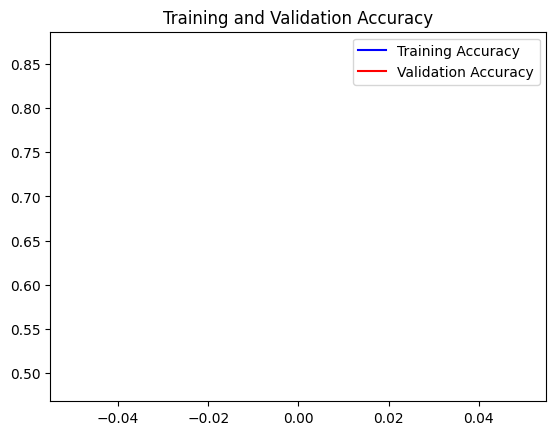

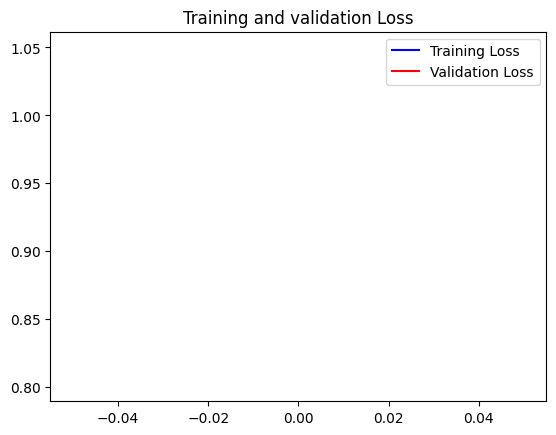

372/372 [==============================] - 4s 10ms/step


In [ ]:
K.clear_session()

model = Sequential()
# input layer is sequence of integers (words)
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQ_LEN, weights=[w2v_embedding_vectors], trainable=False, name="embeddings_layer")) # part of input layer as it transforms integers into dense vectors, input shape = (None, MAX_SEQ_LEN)
model.add(LSTM(64, name='hidden_layer')) # hidden layer
model.add(Dense(NUM_OUTPUT_CLASSES, activation='softmax', name="output_layer"))
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

history = model.fit(x_train_encoded, y_train_encoded, validation_data=(x_val_encoded, y_val_encoded), batch_size=16, epochs=1)

y_pred = model.predict(x_test_encoded)
score = model.evaluate(x_test_encoded, y_test_encoded)

get_results(y_pred, y_test_encoded, x_test_encoded, score, history, model, "LSTM", model.optimizer.get_config(), results_folder_path)

del model

K.clear_session()
tf.compat.v1.reset_default_graph()

In [8]:
K.clear_session()

batch_size= 16
epochs=2

num_layers = Integer(low=1, high=2, name='num_layers')
num_units = Categorical([32, 64, 128], name='num_units')
learning_rate = Categorical([0.1, 1e-2], name='learning_rate')

search_space = [
            num_layers,
            num_units,
            learning_rate
            ]

# Specify one or more initial points for the search of optimal parameter
default_params = [1,
                  32,
                  1e-2
                  ]
                  
def define_model(num_layers, num_units, learning_rate, layer_type):
    # input layer
    inputs = Input(shape=(MAX_SEQ_LEN,), name="input word2vec embeddings")

    # Define an embedding layer for the input
    embeddings = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQ_LEN, weights=[w2v_embedding_vectors], trainable=False, name="embeddingsB")(inputs)

    # Pass embeddings through their own LSTM or GRU layers
    layers = embeddings
    for i in range(num_layers):
        layer_name = 'layer_{0}_{1}'.format(layer_type.__name__, i+1)
        if i < num_layers-1:
            layers = layer_type(num_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, name=layer_name)(layers)
        else:
            layers = layer_type(num_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=False, name=layer_name)(layers)

    # Dense layer for the merged inputs & output Layer
    outputs = Dense(NUM_OUTPUT_CLASSES, activation='softmax', name="output")(layers)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    rmsprop = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=rmsprop, loss='mean_squared_error', metrics=['accuracy']) # default learning rate = 0.001
    print(model.summary())

    return model

In [9]:
def get_objective_function(layer_type):
    @use_named_args(dimensions=search_space)
    def objective_function(num_layers, num_units, learning_rate):

        model = define_model(num_layers=num_layers,
                            num_units=num_units,
                            learning_rate=learning_rate,
                            layer_type=layer_type
                            )

        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = model.fit(x_train_encoded,
                            y_train_encoded,
                            validation_data=(x_val_encoded, y_val_encoded),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=2
                            )
        # Return the validation accuracy for the last epoch.
        accuracy = history.history['val_accuracy'][-1]
        loss = history.history['val_loss'][-1]

        # Print the classification accuracy.
        print(f"Accuracy: {accuracy:.2%}")
        print(f"Loss: {loss:.2}\n")

        del model

        # Clear the session.
        K.clear_session()
        tf.compat.v1.reset_default_graph()

        # The optimizer aims for the lowest score, so we return our negative accuracy.
        return -accuracy

    return objective_function

In [10]:
def perform_bayesian_opt(objective_function):
    # Perform Bayesian Optimization
    gbrt_result = gbrt_minimize(func=objective_function,
                                dimensions=search_space,
                                n_calls=12,
                                n_jobs=-1,
                                x0=default_params)

    gbrt_best_params = {param.name: value for param, value in zip(gbrt_result.space, gbrt_result.x)}
    print("Best Hyperparameters:", gbrt_best_params)
    print()

    return gbrt_best_params

def fit_model(model, model_name, x_train, y_train, x_val, y_val):
    model_file = f"model_{model_name}.h5"
    model_path = os.path.join(results_folder_path, model_file)

    # Check if the model exists
    if os.path.exists(model_path):
        # If the model exists, then load it
        model = load_model(model_path)
        print(f"Model {model_name} loaded successfully")
    else:
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = model.fit(x_train,
                            y_train,
                            validation_data=(x_val, y_val),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=2)

        model.save(model_path)
        print(f"Model {model_name} saved at {model_path}")

    return model, history

def init_results(model, model_name, x_train, y_train, x_val, y_val, x_test, y_test):
    subfolder_path = f"{model_name}_results"
    res_path = os.path.join(results_folder_path, subfolder_path)

    y_pred = model.predict(x_train)
    score = model.evaluate(x_train, y_train)
    get_results(y_pred, y_train, x_train, score, model, f"Train {model_name}", model.optimizer.get_config(), res_path)

    y_pred = model.predict(x_val)
    score = model.evaluate(x_val, y_val)
    get_results(y_pred, y_val, x_val, score, model, f"Val {model_name}", model.optimizer.get_config(), res_path)

    y_pred = model.predict(x_test)
    score = model.evaluate(x_test, y_test)
    get_results(y_pred, y_test, x_test, score, model, f"Test {model_name}", model.optimizer.get_config(), res_path)


def setup_dl(model_name):
    if model_name == "LSTM":
        objective_function = get_objective_function(LSTM)
    else:
        objective_function = get_objective_function(GRU)

    best_params = perform_bayesian_opt(objective_function)

    # Fit best model
    model = define_model(best_params['num_layers'],
                         best_params['num_units'],
                         best_params['learning_rate'],
                         LSTM if model_name == "LSTM" else GRU)


    best_model, history = fit_model(model, model_name, x_train_encoded, y_train_encoded, x_val_encoded, y_val_encoded)

    # Get results
    plot_development(history, model_name)
    init_results(best_model, model_name, x_train_encoded, y_train_encoded, x_val_encoded, y_val_encoded, x_test_encoded, y_test_encoded)

In [11]:
setup_dl("LSTM")

2023-06-25 01:31:57.674910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 390 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:17:00.0, compute capability: 8.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input word2vec embeddings (  [(None, 449)]            0         
 InputLayer)                                                     
                                                                 
 embeddingsB (Embedding)     (None, 449, 100)          1139500   
                                                                 
 layer_LSTM_1 (LSTM)         (None, 32)                17024     
                                                                 
 output (Dense)              (None, 3)                 99        
                                                                 
Total params: 1,156,623
Trainable params: 17,123
Non-trainable params: 1,139,500
_________________________________________________________________
None
Epoch 1/2


2023-06-25 01:32:01.657324: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:219] failed to create cublas handle: the library was not initialized
2023-06-25 01:32:01.657504: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:221] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2023-06-25 01:32:01.657540: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at matmul_op_impl.h:622 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support
2023-06-25 01:32:01.665096: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:219] failed to create cublas handle: the library was not initialized
2023-06-25 01:32:01.665123: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:221] Failure to initialize

InternalError: Graph execution error:

Detected at node 'model/layer_LSTM_1/while/lstm_cell/MatMul_6' defined at (most recent call last):
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/amd/zen3/software/Python/3.10.8-GCCcore-12.2.0/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/amd/zen3/software/Python/3.10.8-GCCcore-12.2.0/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home2/s3985113/venv/thesis/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home2/s3985113/venv/thesis/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home2/s3985113/venv/thesis/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home2/s3985113/venv/thesis/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/amd/zen3/software/Python/3.10.8-GCCcore-12.2.0/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/amd/zen3/software/Python/3.10.8-GCCcore-12.2.0/lib/python3.10/asyncio/base_events.py", line 1899, in _run_once
      handle._run()
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/amd/zen3/software/Python/3.10.8-GCCcore-12.2.0/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home2/s3985113/venv/thesis/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home2/s3985113/venv/thesis/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home2/s3985113/venv/thesis/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home2/s3985113/venv/thesis/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home2/s3985113/venv/thesis/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home2/s3985113/venv/thesis/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home2/s3985113/venv/thesis/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home2/s3985113/venv/thesis/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home2/s3985113/venv/thesis/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home2/s3985113/venv/thesis/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home2/s3985113/venv/thesis/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home2/s3985113/venv/thesis/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2656572/3579812215.py", line 1, in <module>
      setup_dl("LSTM")
    File "/tmp/ipykernel_2656572/134251331.py", line 62, in setup_dl
      best_params = perform_bayesian_opt(objective_function)
    File "/tmp/ipykernel_2656572/134251331.py", line 3, in perform_bayesian_opt
      gbrt_result = gbrt_minimize(func=objective_function,
    File "/home2/s3985113/venv/thesis/lib/python3.10/site-packages/skopt/optimizer/gbrt.py", line 179, in gbrt_minimize
      return base_minimize(func, dimensions, base_estimator,
    File "/home2/s3985113/venv/thesis/lib/python3.10/site-packages/skopt/optimizer/base.py", line 282, in base_minimize
      y0 = list(map(func, x0))
    File "/home2/s3985113/venv/thesis/lib/python3.10/site-packages/skopt/utils.py", line 789, in wrapper
      objective_value = func(**arg_dict)
    File "/tmp/ipykernel_2656572/3060754909.py", line 12, in objective_function
      history = model.fit(x_train_encoded,
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/layers/rnn/base_rnn.py", line 556, in __call__
      return super().__call__(inputs, **kwargs)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/layers/rnn/lstm.py", line 625, in call
      last_output, outputs, states = backend.rnn(
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/backend.py", line 5142, in rnn
      final_outputs = tf.compat.v1.while_loop(
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/backend.py", line 5121, in _step
      output, new_states = step_function(
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/layers/rnn/lstm.py", line 623, in step
      return self.cell(inputs, states, **kwargs)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/layers/rnn/lstm.py", line 323, in call
      c, o = self._compute_carry_and_output(x, h_tm1, c_tm1)
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/layers/rnn/lstm.py", line 255, in _compute_carry_and_output
      + backend.dot(
    File "/cvmfs/hpc.rug.nl/versions/2023.01/rocky8/x86_64/intel/icelake/software/TensorFlow/2.11.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/keras/backend.py", line 2455, in dot
      out = tf.matmul(x, y)
Node: 'model/layer_LSTM_1/while/lstm_cell/MatMul_6'
Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[{{node model/layer_LSTM_1/while/lstm_cell/MatMul_6}}]] [Op:__inference_train_function_3977]

In [ ]:
setup_dl("GRU")